# Установка необходимых библиотек

- `catboost` – библиотека градиентного бустинга от Яндекса, оптимизированная для категориальных признаков. Обеспечивает высокую точность, быструю скорость обучения и простоту использования.

- `optuna` – современная библиотека автоматизированного подбора гиперпараметров с использованием продвинутых алгоритмов оптимизации. Позволяет эффективно искать лучшие параметры моделей.

- `shap` – библиотека для интерпретации моделей машинного обучения с использованием SHAP-значений (Shapley values). Помогает понять вклад каждого признака в предсказание модели.

In [1]:
!pip install catboost optuna shap

# Подготовка к обучению и интерпретации

## Импорт библиотек

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
import shap

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

## Загрузка датасета

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Этот набор данных содержит `9_538` медицинских записей, связанных с диагнозом диабета и факторами риска. Он включает различные параметры здоровья, привычки образа жизни и генетическую предрасположенность, которые вносят свой вклад в риск развития диабета. Данные структурированы с реалистичным распределением, что делает их ценными для медицинских исследований, статистического анализа и приложений машинного обучения.

| Фактор             | Описание | Диапазон значений |
|--------------------|---------|------------------|
| **Age** | Возраст пациента | 18 - 90 лет |
| **Pregnancies** | Количество беременностей (для женщин) | Целые числа (0+) |
| **BMI** | Индекс массы тела (вес/рост²) | Положительные числа |
| **Glucose** | Уровень глюкозы в крови (mg/dL) | Положительные числа |
| **BloodPressure** | Систолическое давление (mmHg) | Положительные числа |
| **HbA1c** | Уровень гемоглобина A1c (%) | Положительные числа |
| **LDL** | "Плохой" холестерин (mg/dL) | Положительные числа |
| **HDL** | "Хороший" холестерин (mg/dL) | Положительные числа |
| **Triglycerides** | Триглицериды в крови (mg/dL) | Положительные числа |
| **WaistCircumference** | Окружность талии (см) | Положительные числа |
| **HipCircumference** | Окружность бедер (см) | Положительные числа |
| **WHR** | Соотношение талия/бедра | Положительные числа |
| **FamilyHistory** | Наличие диабета у родственников | 0 = Нет, 1 = Да |
| **DietType** | Тип питания | 0 = Несбалансированное, 1 = Сбалансированное, 2 = Веган/вегетарианское |
| **Hypertension** | Гипертония | 0 = Нет, 1 = Да |
| **MedicationUse** | Прием лекарств | 0 = Нет, 1 = Да |
| **Outcome** | Диагноз диабета | 0 = Нет, 1 = Да |


In [4]:
df = pd.read_csv('drive/MyDrive/diabetes_dataset.csv')

In [5]:
df.head(2)

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  MedicationUse       9538 non-null   int64  
 16  Outcom

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
count,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000
mean,53.577584,7.986161,27.052364,106.104183,84.475781,4.650661,100.133456,49.953418,151.147746,93.951678,103.060621,0.917400,0.302474,0.486161,0.001048,0.405012,0.344097
std,20.764651,4.933469,5.927955,21.918590,14.123480,0.476395,29.911910,15.242194,48.951627,15.594468,13.438827,0.140828,0.459354,0.661139,0.032364,0.490920,0.475098
min,18.000000,0.000000,15.000000,50.000000,60.000000,4.000000,-12.000000,-9.200000,50.000000,40.300000,54.800000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,4.000000,22.870000,91.000000,74.000000,4.300000,80.100000,39.700000,117.200000,83.400000,94.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,8.000000,27.050000,106.000000,84.000000,4.600000,99.900000,50.200000,150.550000,93.800000,103.200000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.000000,12.000000,31.180000,121.000000,94.000000,5.000000,120.200000,60.200000,185.100000,104.600000,112.100000,1.010000,1.000000,1.000000,0.000000,1.000000,1.000000
max,89.000000,16.000000,49.660000,207.200000,138.000000,6.900000,202.200000,107.800000,345.800000,163.000000,156.600000,1.490000,1.000000,2.000000,1.000000,1.000000,1.000000


In [7]:
def show_corr_matrix(dataset, drawing=True):
    if drawing:
        plt.figure(figsize=(12, 8))
        sns.heatmap(dataset.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
        plt.title('Корреляционная матрица')
        plt.show()

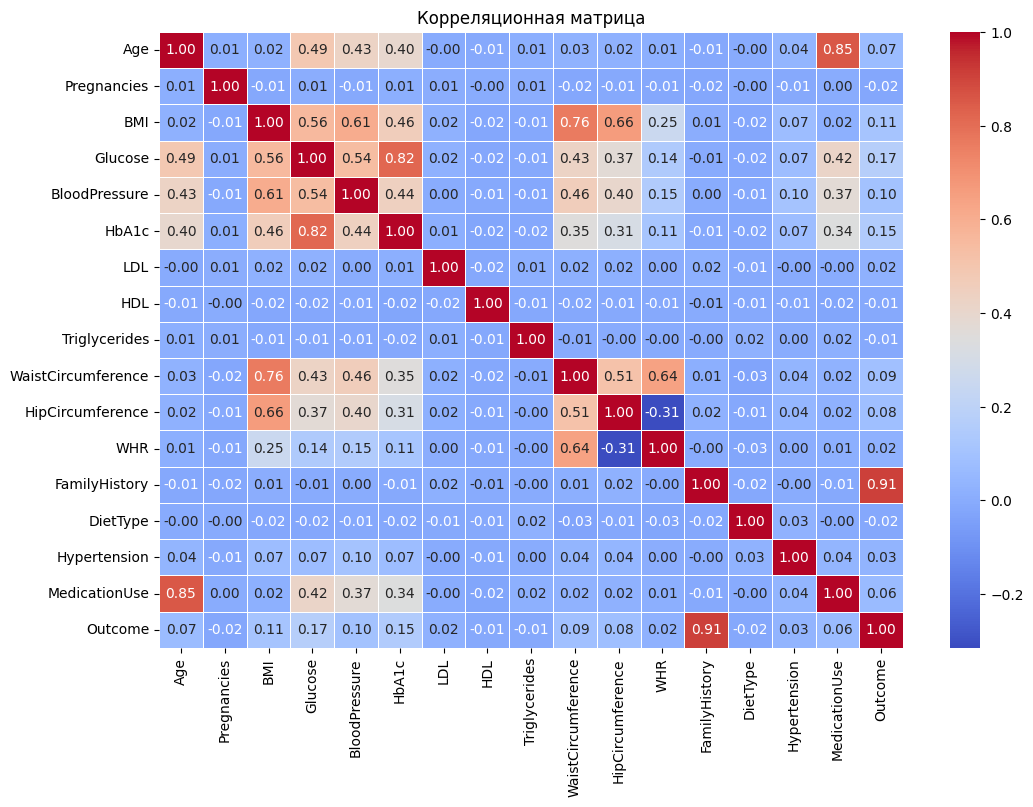

In [8]:
show_corr_matrix(df)

## Очистка от выбросов

Функция `remove_outliers(df, columns)` удаляет выбросы из заданных числовых признаков с помощью метода межквартильного размаха (IQR, Interquartile Range).

###  Метод межквартильного размаха

Для признака $X$, пусть:

* $Q_1 = \text{quantile}_{0.25}(X)$
* $Q_3 = \text{quantile}_{0.75}(X)$
* $\text{IQR} = Q_3 - Q_1$

Тогда **выбросами** считаются значения, выходящие за границы:

$$
X < Q_1 - 1.5 \cdot \text{IQR} \quad \text{или} \quad X > Q_3 + 1.5 \cdot \text{IQR}
$$

Эти точки называются **границами выбросов**. Всё, что за пределами — считается слишком маленьким или слишком большим для «нормального» диапазона.

In [9]:
# Метод межквартильного размаха
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR)))]
    return df


# числовые признаки
numeric_featuries = [
    'Age', 'Pregnancies', 'BMI', 'Glucose', 'BloodPressure', 'HbA1c', 'LDL',
    'HDL', 'Triglycerides', 'WaistCircumference', 'HipCircumference', 'WHR'
]

df_clean = remove_outliers(df, numeric_featuries)
print(f"Удалено {len(df)-len(df_clean)} выбросов")

Удалено 466 выбросов


In [10]:
df_clean.head(2)

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 9072 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9072 non-null   int64  
 1   Pregnancies         9072 non-null   int64  
 2   BMI                 9072 non-null   float64
 3   Glucose             9072 non-null   float64
 4   BloodPressure       9072 non-null   float64
 5   HbA1c               9072 non-null   float64
 6   LDL                 9072 non-null   float64
 7   HDL                 9072 non-null   float64
 8   Triglycerides       9072 non-null   float64
 9   WaistCircumference  9072 non-null   float64
 10  HipCircumference    9072 non-null   float64
 11  WHR                 9072 non-null   float64
 12  FamilyHistory       9072 non-null   int64  
 13  DietType            9072 non-null   int64  
 14  Hypertension        9072 non-null   int64  
 15  MedicationUse       9072 non-null   int64  
 16  Outcome    

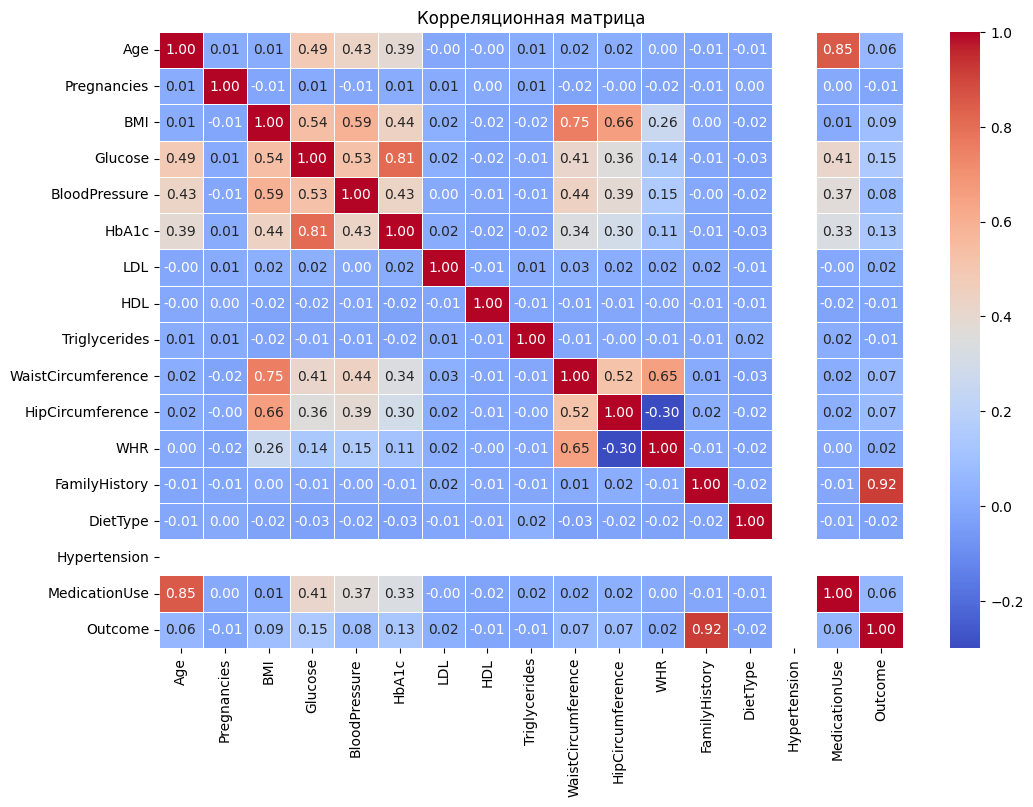

In [11]:
df_clean.info()
show_corr_matrix(df_clean)

In [12]:
# Удаление полностью нулевой фичи после очистки
df_clean = df_clean.drop('Hypertension', axis=1)

## Feature tuning

Добавим новые признаки, чтобы можно было исследовать новые, более сложные закономерности

In [13]:
df_final = df_clean.copy()

### Добавление простых фичей (признаков)

#### 1. `BMI_Category` – категориальный признак на основе ИМТ (индекса массы тела):

```python
df_final['BMI_Category'] = pd.cut(
    df_final['BMI'],
    bins=[0, 18.5, 25, 30, np.inf],
    labels=[0, 1, 2, 3]
).astype(int)
```

Разбивает людей на группы:
  
  - `0`: дефицит массы (BMI < 18.5)
  
  - `1`: нормальный вес (18.5–25)
  
  - `2`: избыточный вес (25–30)
  
  - `3`: ожирение (BMI > 30)

> Используется `pd.cut` для биннинга непрерывного признака.

#### 2. `CholesterolRatio` – соотношение плохого к хорошему холестерину:

```python
df_final['CholesterolRatio'] = df_final['LDL'] / df_final['HDL']
```

> **LDL** — «плохой» холестерин, **HDL** — «хороший».

> Высокое соотношение → выше риск сердечно-сосудистых заболеваний.

---

#### 3. `Glucose_HbA1c_Ratio` – отношение текущего сахара к долгосрочному:

```python
df_final['Glucose_HbA1c_Ratio'] = df_final['Glucose'] / df_final['HbA1c']
```

> Помогает оценить, насколько текущий уровень глюкозы отклоняется от долгосрочного контроля (HbA1c).

> Может выявлять резкие скачки сахара (например, при нарушенной толерантности к глюкозе).




In [14]:
# BMI-категории (0: дефицит, 1: норма, 2: избыточный вес, 3: ожирение)
df_final['BMI_Category'] = pd.cut(
    df_final['BMI'],
    bins=[0, 18.5, 25, 30, np.inf],
    labels=[0, 1, 2, 3]
).astype(int)

# Соотношение плохого/хорошего холестерина
df_final['CholesterolRatio'] = df_final['LDL'] / df_final['HDL']

# Соотношение глюкозы к HbA1c (текущий/долгосрочный сахар)
df_final['Glucose_HbA1c_Ratio'] = df_final['Glucose'] / df_final['HbA1c']

### Индикаторы (бинарные признаки):

#### 1. `IsObese` – признак ожирения:

```python
df_final['IsObese'] = (df_final['BMI'] > 30).astype(int)
```

> 1, если у человека ожирение (по стандарту BMI > 30), иначе 0.


#### 2. `HasMetabolicSyndrome` – признак метаболического синдрома (упрощённо):

```python
df_final['HasMetabolicSyndrome'] = (
    (df_final['BMI'] > 30) &
    (df_final['Glucose'] > 126) &
    (df_final['LDL'] > 160)
).astype(int)
```

> Примерная логика определения метаболического синдрома: `ожирение + сахар > 126 мг/дл + высокий уровень LDL`

> Выставляется `1`, если все условия соблюдаются.

---

#### 3. `IsElderly` – признак пожилого возраста:

```python
df_final['IsElderly'] = (df_final['Age'] > 60).astype(int)
```

> `1`, если возраст больше 60 лет.

---

#### 4. `HighTriglycerides` – повышенные триглицериды:

```python
df_final['HighTriglycerides'] = (df_final['Triglycerides'] > 150).astype(int)
```

> `1`, если уровень триглицеридов выше нормы (>150 мг/дл), что повышает сердечно-сосудистые риски.

---

#### 5. `GoodHDL` – высокий уровень "хорошего" холестерина:

```python
df_final['GoodHDL'] = (df_final['HDL'] > 60).astype(int)
```

> `1`, если HDL > 60 мг/дл — считается защитным фактором для сердца.

Эти признаки должны **хорошо работать** в моделях, особенно в деревьях (`CatBoost`, `XGBoost`), и могут заметно повысить интерпретируемость и точность.


In [15]:
# Индикатор ожирения
df_final['IsObese'] = (df_final['BMI'] > 30).astype(int)

# Индикатор "Метаболического синдрома" (примерный)
df_final['HasMetabolicSyndrome'] = (
    (df_final['BMI'] > 30) &
    (df_final['Glucose'] > 126) &
    (df_final['LDL'] > 160)
).astype(int)

# Возраст > 60
df_final['IsElderly'] = (df_final['Age'] > 60).astype(int)

# Повышенные триглицериды
df_final['HighTriglycerides'] = (df_final['Triglycerides'] > 150).astype(int)

# Хороший HDL (>60)
df_final['GoodHDL'] = (df_final['HDL'] > 60).astype(int)

### **Описание взаимодействий:**

#### 1. `GlucoseByDiet` – взаимодействие глюкозы и типа диеты:

```python
df_final['GlucoseByDiet'] = df_final['Glucose'] * df_final['DietType']
```

> Показывает, как уровень глюкозы **изменяется в зависимости от типа питания**.

> Если `DietType` — закодированная категория (например, 0 = обычная, 1 = диабетическая и т.п.), это может выявить влияние диеты на сахар.

#### 2. `Age_x_Medication` – взаимодействие возраста и приёма лекарств:

```python
df_final['Age_x_Medication'] = df_final['Age'] * df_final['MedicationUse']
```

> Показывает, как **возраст влияет на эффект или необходимость лечения**.

> Например, пожилые люди чаще принимают препараты — эта фича может быть маркером прогрессирующего заболевания.

In [16]:
df_final['GlucoseByDiet'] = df_final['Glucose'] * df_final['DietType']
df_final['Age_x_Medication'] = df_final['Age'] * df_final['MedicationUse']

### Описание датасета и корр. матрица признаков после изменения

In [17]:
df_final.head(2)

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,...,BMI_Category,CholesterolRatio,Glucose_HbA1c_Ratio,IsObese,HasMetabolicSyndrome,IsElderly,HighTriglycerides,GoodHDL,GlucoseByDiet,Age_x_Medication
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,...,2,2.963636,24.092593,0,0,1,0,0,0.0,69
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,...,2,1.980634,20.612245,0,0,1,1,0,0.0,89


In [18]:
df_final.info()
df_final.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9072 entries, 0 to 9537
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9072 non-null   int64  
 1   Pregnancies           9072 non-null   int64  
 2   BMI                   9072 non-null   float64
 3   Glucose               9072 non-null   float64
 4   BloodPressure         9072 non-null   float64
 5   HbA1c                 9072 non-null   float64
 6   LDL                   9072 non-null   float64
 7   HDL                   9072 non-null   float64
 8   Triglycerides         9072 non-null   float64
 9   WaistCircumference    9072 non-null   float64
 10  HipCircumference      9072 non-null   float64
 11  WHR                   9072 non-null   float64
 12  FamilyHistory         9072 non-null   int64  
 13  DietType              9072 non-null   int64  
 14  MedicationUse         9072 non-null   int64  
 15  Outcome               9072

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,...,BMI_Category,CholesterolRatio,Glucose_HbA1c_Ratio,IsObese,HasMetabolicSyndrome,IsElderly,HighTriglycerides,GoodHDL,GlucoseByDiet,Age_x_Medication
count,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,...,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000,9072.000000
mean,53.353505,7.984237,26.926893,105.585516,84.186949,4.639021,100.342824,50.011795,150.609799,93.576334,...,1.853946,2.247884,22.615632,0.304233,0.002425,0.399912,0.501543,0.251543,50.895877,29.985450
std,20.720559,4.937318,5.745200,21.322962,13.804056,0.463843,29.104693,14.686449,48.374014,14.988918,...,0.946099,1.180441,3.152209,0.460107,0.049188,0.489907,0.500025,0.433924,71.387328,37.101918
min,18.000000,0.000000,15.000000,50.000000,60.000000,4.000000,20.000000,9.100000,50.000000,52.000000,...,0.000000,0.252071,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,4.000000,22.870000,90.900000,74.000000,4.300000,80.300000,39.900000,117.075000,83.300000,...,1.000000,1.499822,20.665000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,8.000000,26.980000,105.600000,84.000000,4.600000,100.100000,50.200000,150.200000,93.500000,...,2.000000,2.015786,22.813953,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,71.000000,12.000000,30.992500,120.500000,94.000000,5.000000,120.200000,60.100000,184.800000,104.000000,...,3.000000,2.692161,24.855195,1.000000,0.000000,1.000000,1.000000,1.000000,103.700000,71.000000
max,89.000000,16.000000,43.630000,165.100000,124.000000,6.000000,180.300000,90.900000,286.600000,135.900000,...,3.000000,16.222222,30.980769,1.000000,1.000000,1.000000,1.000000,1.000000,323.200000,89.000000


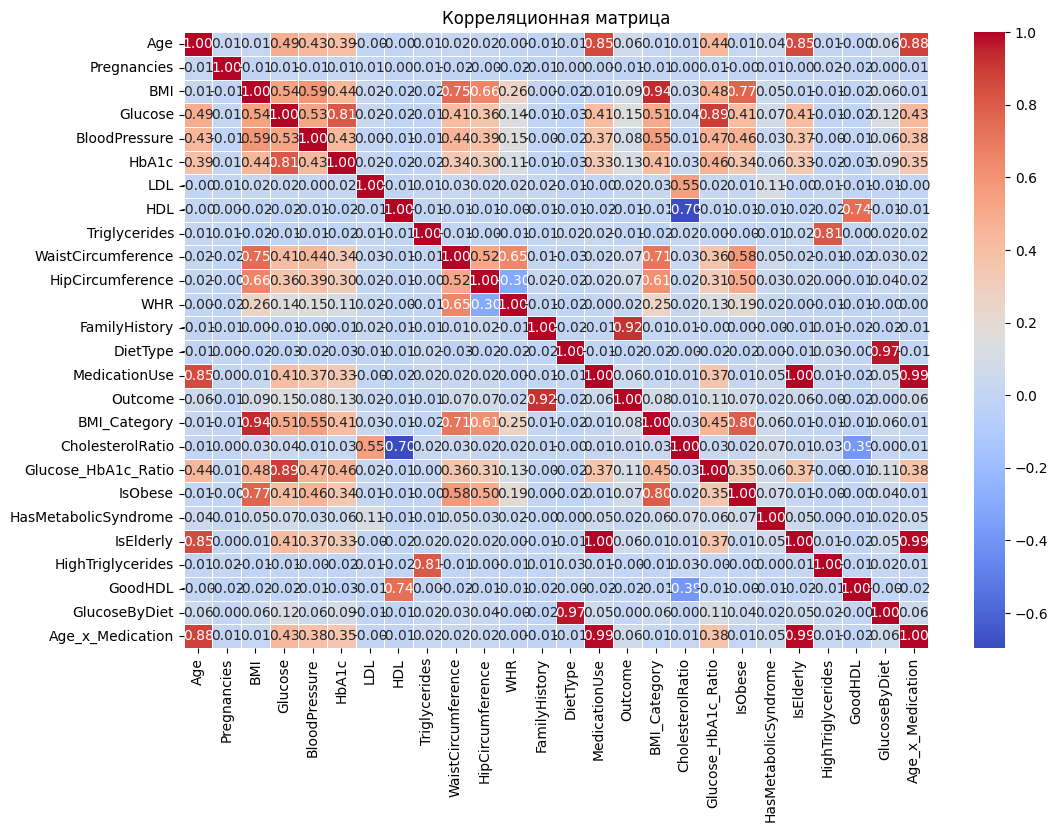

In [19]:
show_corr_matrix(df_final)

## CatBoost


Проверка доступности `GPU`

In [20]:
isGPU = None
devices = tf.config.list_physical_devices('GPU')
if devices:
    isGPU = True
    print("Доступна видеокарта (GPU):", devices)
else:
    isGPU = False
    print("GPU не доступен, используется CPU.")

Доступна видеокарта (GPU): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Разделение на признаки и целевую переменную

In [ ]:
X = df_final.drop(columns=["Outcome"], axis=1)
X = X.drop(columns=["FamilyHistory"], axis=1) # С FamilyHistory, обучается и смотрит только на нее
y = df_final["Outcome"]

### Подбор гиперпараметров для задачи классификации

- **Функция `objective(trial)`**:

    - `iterations` — число итераций (деревьев)

    - `learning_rate` — скорость обучения (логарифмически)

    - `depth` — глубина дерева

    - `subsample`, `colsample_bylevel` — доли данных и признаков

    - `min_data_in_leaf` — минимальное число объектов в листе

    - `task_type`: выбирается **GPU или CPU** в зависимости от `isGPU`.


- **Кросс-валидация**

    ```python
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    ```

    - Проводится **стратифицированная 5-кратная кросс-валидация**.

    - Метрика: **ROC AUC** (чем выше — тем лучше).

    - `cross_val_score` обучает модель 5 раз с разными разбиениями и считает средний результат.

In [ ]:
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "iterations": trial.suggest_int('iterations', 300, 500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 6, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bylevel": trial.suggest_float('colsample_bylevel', 0.05, 1.0) if not isGPU else None,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'bootstrap_type': 'Bernoulli',
        'task_type': 'GPU' if isGPU else 'CPU',
        'verbose': False,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(**params)

        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=20,
            verbose=False
        )

        preds = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, preds)
        aucs.append(auc)

    return np.mean(aucs)

study = optuna.create_study(direction='maximize', study_name='CatBoost Diabetes')
study.optimize(objective, n_trials=12)

[I 2025-06-02 12:16:26,014] A new study created in memory with name: CatBoost Diabetes
[I 2025-06-02 12:17:20,934] Trial 0 finished with value: 0.5846338797973294 and parameters: {'iterations': 485, 'learning_rate': 0.00833667146005657, 'depth': 7, 'subsample': 0.8097533354715456, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.5846338797973294.
[I 2025-06-02 12:17:35,725] Trial 1 finished with value: 0.5869881291513094 and parameters: {'iterations': 403, 'learning_rate': 0.0027934239037173143, 'depth': 6, 'subsample': 0.8798601350571063, 'min_data_in_leaf': 51}. Best is trial 1 with value: 0.5869881291513094.
[I 2025-06-02 12:17:39,430] Trial 2 finished with value: 0.5835958916564079 and parameters: {'iterations': 384, 'learning_rate': 0.09795057906969903, 'depth': 7, 'subsample': 0.7411672386282027, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.5869881291513094.
[I 2025-06-02 12:17:48,584] Trial 3 finished with value: 0.5828468149319684 and parameters: {'iterations': 4

Результаты подборки гиперпараметров

In [23]:
print("Best trial:")
print(study.best_trial)
print("Best params:")
print(study.best_trial.params)

Best trial:
FrozenTrial(number=8, state=1, values=[0.5907217685953791], datetime_start=datetime.datetime(2025, 6, 2, 12, 18, 28, 782708), datetime_complete=datetime.datetime(2025, 6, 2, 12, 18, 47, 426933), params={'iterations': 328, 'learning_rate': 0.00923247211802987, 'depth': 9, 'subsample': 0.5369304942289184, 'min_data_in_leaf': 83}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=300, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=6, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.5, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1)}, trial_id=8, value=None)
Best params:
{'iterations': 328, 'learning_rate': 0.00923247211802987, 'depth': 9, 'subsample': 0.5369304942289184, 'min_data_in_leaf': 83}


### Обучение CatBoostClassifier на лучших гиперпараметрах

In [24]:
# Обучение на наилучших параметрах
best_model = CatBoostClassifier(**study.best_params)
best_model.fit(X, y)

0:	learn: 0.6906175	total: 44.6ms	remaining: 14.6s
1:	learn: 0.6881095	total: 77ms	remaining: 12.6s
2:	learn: 0.6856486	total: 121ms	remaining: 13.1s
3:	learn: 0.6831338	total: 162ms	remaining: 13.1s
4:	learn: 0.6809741	total: 194ms	remaining: 12.5s
5:	learn: 0.6784219	total: 233ms	remaining: 12.5s
6:	learn: 0.6764925	total: 273ms	remaining: 12.5s
7:	learn: 0.6744397	total: 308ms	remaining: 12.3s
8:	learn: 0.6721628	total: 341ms	remaining: 12.1s
9:	learn: 0.6700451	total: 365ms	remaining: 11.6s
10:	learn: 0.6678567	total: 386ms	remaining: 11.1s
11:	learn: 0.6657150	total: 414ms	remaining: 10.9s
12:	learn: 0.6637533	total: 446ms	remaining: 10.8s
13:	learn: 0.6617659	total: 486ms	remaining: 10.9s
14:	learn: 0.6598613	total: 520ms	remaining: 10.8s
15:	learn: 0.6582371	total: 552ms	remaining: 10.8s
16:	learn: 0.6564438	total: 580ms	remaining: 10.6s
17:	learn: 0.6547562	total: 612ms	remaining: 10.5s
18:	learn: 0.6530906	total: 654ms	remaining: 10.6s
19:	learn: 0.6515490	total: 691ms	remaini

## Интерпретируемость

`SHAP` — это метод интерпретации моделей машинного обучения на основе теории игр. Он объясняет вклад каждого признака в конкретное предсказание модели, используя значения Шепли (Shapley values).

`SHAP` позволяет понять: почему модель приняла то или иное решение, а не просто "какие признаки важны".

### Глобальная интерпретация (на всех даннх)

Полготовка `explainer`

In [25]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)

`Bar plot` - отображает среднее абсолютное SHAP-значение для каждого признака.

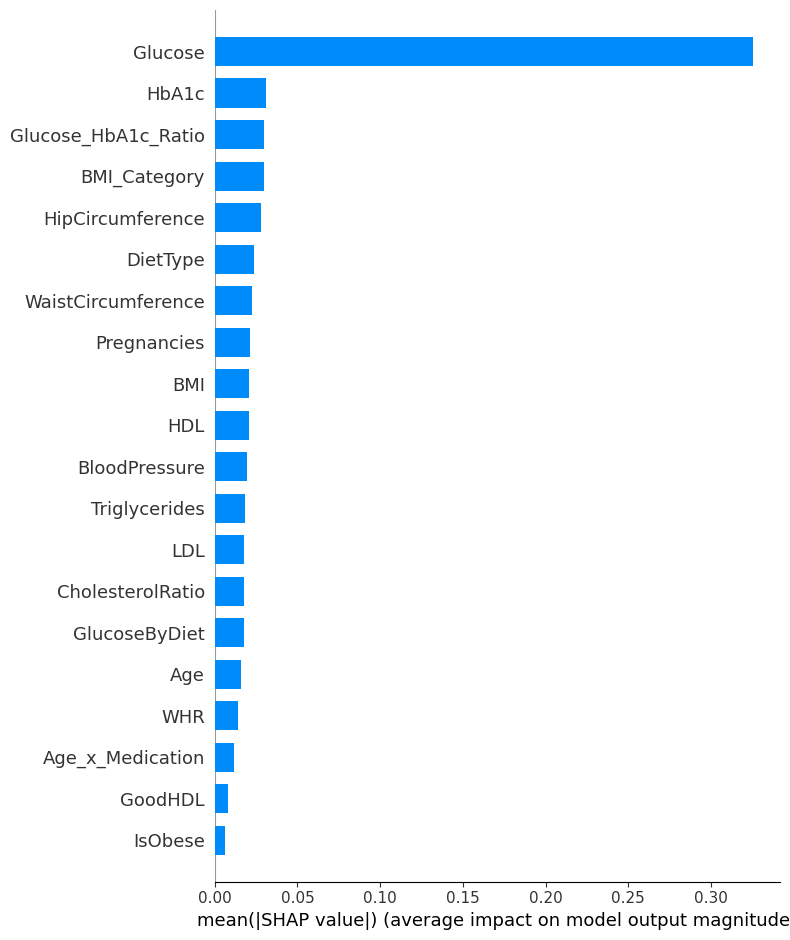

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar")

`Beeswarm plot` (распределение влияния признаков) - важность и направление влияния признака.

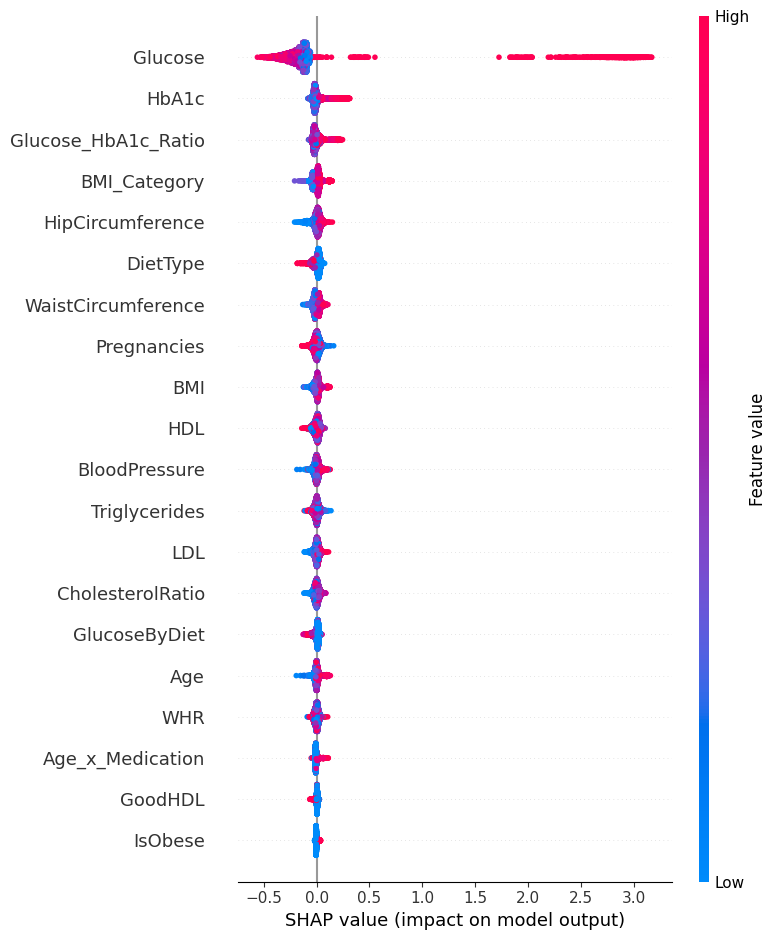

In [ ]:
shap.summary_plot(shap_values, X)

Взаимосвязь признаков

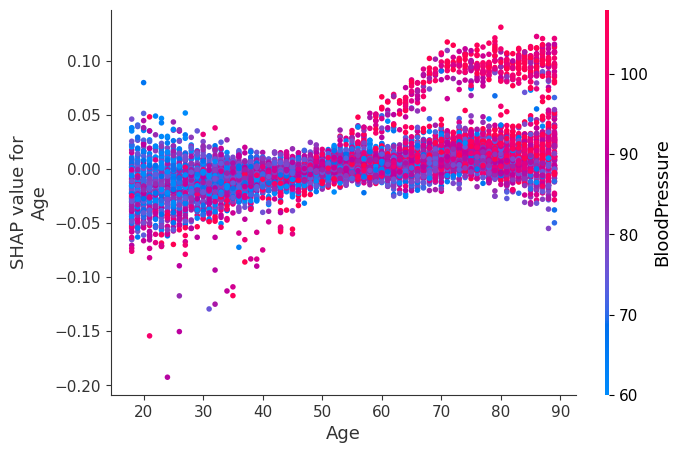

In [28]:
shap.dependence_plot('Age', shap_values, interaction_index='BloodPressure', features=X)

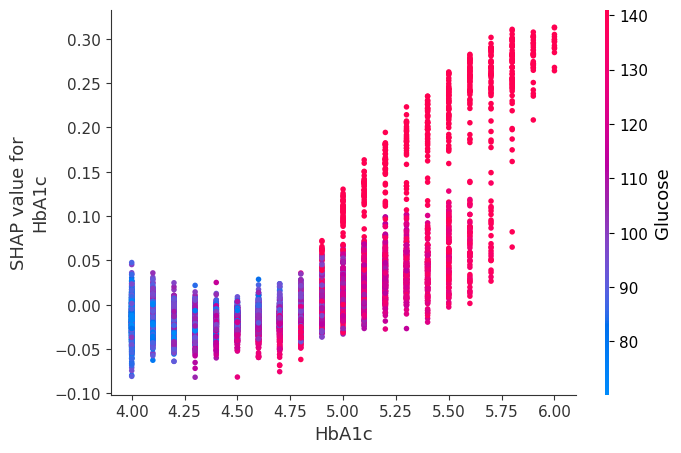

In [29]:
shap.dependence_plot('HbA1c', shap_values, interaction_index='Glucose', features=X)

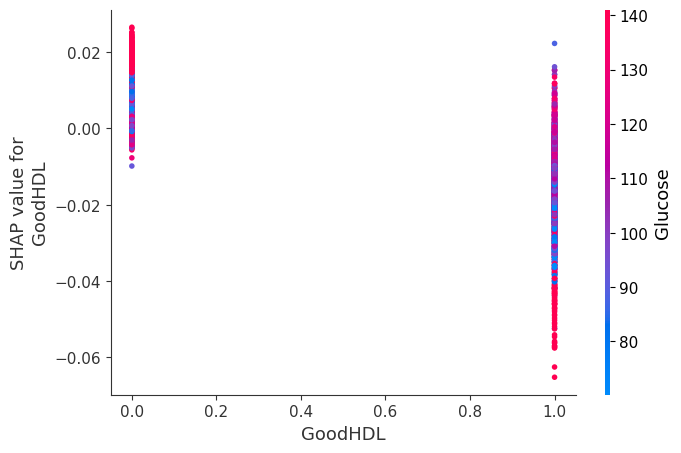

In [30]:
shap.dependence_plot('GoodHDL', shap_values, interaction_index='Glucose', features=X)

### Локальная интерпретация

In [ ]:
shap.initjs()
idx = 4
shap.force_plot(explainer.expected_value, shap_values[idx,:], X.iloc[idx,:])

Локальная интерпретация на других данных


In [ ]:
new_person = pd.DataFrame([{
    'Age': 22,
    'Pregnancies': 0,
    'BMI': 26.92,
    'Glucose': 105.585516,
    'BloodPressure': 84.1869,
    'HbA1c': 4.639,
    'LDL': 100.342,
    'HDL': 50.0118,
    'Triglycerides': 150.6098,
    'WaistCircumference': 93.5763,
    'HipCircumference': 107.2,
    'WHR': 0.75,
    'FamilyHistory': 0,
    'DietType': 0,
    'Hypertension': 0,
    'MedicationUse': 0,
    'BMI_Category': 1,
    'CholesterolRatio': 2.247884,
    'Glucose_HbA1c_Ratio': 22.615632,
    'IsObese': 0,
    'HasMetabolicSyndrome': 0,
    'IsElderly': 0,
    'HighTriglycerides': 0,
    'GoodHDL': 0,
    'GlucoseByDiet': 50.895877,
    'Age_x_Medication': 0,
}])

result = best_model.predict(new_person)
print(f'Предсказание диабета: {result}')

# Получаем SHAP значения для этого человека
new_shap_values = explainer.shap_values(new_person)
shap.initjs()
shap.force_plot(explainer.expected_value, new_shap_values[0], new_person.iloc[0])


Предсказание диабета: [0]


In [ ]:
new_person = pd.DataFrame([{
    'Age': 22,
    'Pregnancies': 0,
    'BMI': 26.92,
    'Glucose': 150.585516,  # большое значение глюкозы
    'BloodPressure': 84.1869,
    'HbA1c': 4.639,
    'LDL': 100.342,
    'HDL': 50.0118,
    'Triglycerides': 150.6098,
    'WaistCircumference': 93.5763,
    'HipCircumference': 107.2,
    'WHR': 0.75,
    'FamilyHistory': 0,
    'DietType': 0,
    'Hypertension': 0,
    'MedicationUse': 0,
    'BMI_Category': 1,
    'CholesterolRatio': 2.247884,
    'Glucose_HbA1c_Ratio': 22.615632,
    'IsObese': 0,
    'HasMetabolicSyndrome': 0,
    'IsElderly': 0,
    'HighTriglycerides': 0,
    'GoodHDL': 0,
    'GlucoseByDiet': 50.895877,
    'Age_x_Medication': 0,
}])

result = best_model.predict(new_person)
print(f'Предсказание диабета: {result}')

new_shap_values = explainer.shap_values(new_person)

shap.initjs()
shap.force_plot(explainer.expected_value, new_shap_values[0], new_person.iloc[0])


Предсказание диабета: [1]
